<a href="https://colab.research.google.com/github/geet121/Projects/blob/main/Solar_power_prediction_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings 
import os
from datetime import datetime
from keras.callbacks import ModelCheckpoint
from xgboost import XGBRegressor


warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

import logging

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Pasion et al dataset.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21045 entries, 0 to 21044
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Location       21045 non-null  object 
 1   Date           21045 non-null  int64  
 2   Time           21045 non-null  int64  
 3   Latitude       21045 non-null  float64
 4   Longitude      21045 non-null  float64
 5   Altitude       21045 non-null  int64  
 6   YRMODAHRMI     21045 non-null  float64
 7   Month          21045 non-null  int64  
 8   Hour           21045 non-null  int64  
 9   Season         21045 non-null  object 
 10  Humidity       21045 non-null  float64
 11  AmbientTemp    21045 non-null  float64
 12  PolyPwr        21045 non-null  float64
 13  Wind.Speed     21045 non-null  int64  
 14  Visibility     21045 non-null  float64
 15  Pressure       21045 non-null  float64
 16  Cloud.Ceiling  21045 non-null  int64  
dtypes: float64(8), int64(7), object(2)
memory usage: 2

In [5]:
df.head()

Location      Date  Time  Latitude  Longitude  Altitude    YRMODAHRMI  \
0  Camp Murray  20171203  1145     47.11    -122.57        84  2.017120e+11   
1  Camp Murray  20171203  1315     47.11    -122.57        84  2.017120e+11   
2  Camp Murray  20171203  1330     47.11    -122.57        84  2.017120e+11   
3  Camp Murray  20171204  1230     47.11    -122.57        84  2.017120e+11   
4  Camp Murray  20171204  1415     47.11    -122.57        84  2.017120e+11   

   Month  Hour  Season  Humidity  AmbientTemp  PolyPwr  Wind.Speed  \
0     12    11  Winter  81.71997     12.86919  2.42769           5   
1     12    13  Winter  96.64917      9.66415  2.46273           0   
2     12    13  Winter  93.61572     15.44983  4.46836           5   
3     12    12  Winter  77.21558     10.36659  1.65364           5   
4     12    14  Winter  54.80347     16.85471  6.57939           3   

   Visibility  Pressure  Cloud.Ceiling  
0        10.0    1010.6            722  
1        10.0    1011.3             23  
2        10.0    1011.6             32  
3         2.0    1024.4              6  
4         3.0    1023.7              9

In [6]:
df.isna().sum()

Location         0
Date             0
Time             0
Latitude         0
Longitude        0
Altitude         0
YRMODAHRMI       0
Month            0
Hour             0
Season           0
Humidity         0
AmbientTemp      0
PolyPwr          0
Wind.Speed       0
Visibility       0
Pressure         0
Cloud.Ceiling    0
dtype: int64

In [7]:
df.describe()

Date          Time      Latitude     Longitude      Altitude  \
count  2.104500e+04  21045.000000  21045.000000  21045.000000  21045.000000   
mean   2.017720e+07   1267.483725     38.213823   -108.593678    798.843668   
std    4.579585e+03    167.602767      6.323761     16.364130    770.681794   
min    2.017052e+07   1000.000000     20.890000   -156.440000      1.000000   
25%    2.017111e+07   1100.000000     38.160000   -117.260000      2.000000   
50%    2.018032e+07   1300.000000     38.950000   -111.180000    458.000000   
75%    2.018062e+07   1400.000000     41.150000   -104.710000   1370.000000   
max    2.018100e+07   1545.000000     47.520000    -80.110000   1947.000000   

         YRMODAHRMI         Month          Hour      Humidity   AmbientTemp  \
count  2.104500e+04  21045.000000  21045.000000  21045.000000  21045.000000   
mean   2.017718e+11      6.565883     12.627845     37.121941     29.285117   
std    4.579846e+07      2.983958      1.672952     23.823011     12.366820   
min    2.017050e+11      1.000000     10.000000      0.000000    -19.981770   
25%    2.017110e+11      4.000000     11.000000     17.529300     21.915280   
50%    2.018030e+11      7.000000     13.000000     33.123780     30.289150   
75%    2.018060e+11      9.000000     14.000000     52.593990     37.474670   
max    2.018100e+11     12.000000     15.000000     99.987790     65.738370   

            PolyPwr    Wind.Speed    Visibility      Pressure  Cloud.Ceiling  
count  21045.000000  21045.000000  21045.000000  21045.000000   21045.000000  
mean      12.978583     10.318318      9.700071    925.944747     515.966785  
std        7.123255      6.385030      1.351949     85.215659     301.903379  
min        0.257330      0.000000      0.000000    781.700000       0.000000  
25%        6.404570      6.000000     10.000000    845.500000     140.000000  
50%       13.798700      9.000000     10.000000    961.100000     722.000000  
75%       18.863650     14.000000     10.000000   1008.900000     722.000000  
max       34.285020     49.000000     10.000000   1029.500000     722.000000

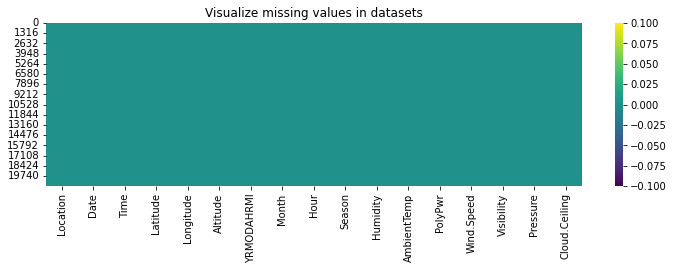

In [8]:
plt.figure(figsize=(12, 3))
sns.heatmap(df.isnull(), cmap='viridis');
plt.title('Visualize missing values in datasets');

In [9]:
# Encode location data
df_location = pd.get_dummies(df, columns=['Location'], drop_first=True)
df_location

Date  Time  Latitude  Longitude  Altitude    YRMODAHRMI  Month  \
0      20171203  1145     47.11    -122.57        84  2.017120e+11     12   
1      20171203  1315     47.11    -122.57        84  2.017120e+11     12   
2      20171203  1330     47.11    -122.57        84  2.017120e+11     12   
3      20171204  1230     47.11    -122.57        84  2.017120e+11     12   
4      20171204  1415     47.11    -122.57        84  2.017120e+11     12   
...         ...   ...       ...        ...       ...           ...    ...   
21040  20180928  1530     38.95    -104.83      1947  2.018090e+11      9   
21041  20180929  1300     38.95    -104.83      1947  2.018090e+11      9   
21042  20180929  1400     38.95    -104.83      1947  2.018090e+11      9   
21043  20180929  1500     38.95    -104.83      1947  2.018090e+11      9   
21044  20181001  1400     38.95    -104.83      1947  2.018100e+11     10   

       Hour  Season  Humidity  ...  Location_Hill Weber  Location_JDMT  \
0        11  Winter  81.71997  ...                    0              0   
1        13  Winter  96.64917  ...                    0              0   
2        13  Winter  93.61572  ...                    0              0   
3        12  Winter  77.21558  ...                    0              0   
4        14  Winter  54.80347  ...                    0              0   
...     ...     ...       ...  ...                  ...            ...   
21040    15    Fall  11.66992  ...                    0              0   
21041    13    Fall  18.22510  ...                    0              0   
21042    14    Fall  15.52124  ...                    0              0   
21043    15    Fall   6.63452  ...                    0              0   
21044    14    Fall  22.58301  ...                    0              0   

       Location_Kahului  Location_MNANG  Location_Malmstrom  \
0                     0               0                   0   
1                     0               0                   0   
2                     0               0                   0   
3                     0               0                   0   
4                     0               0                   0   
...                 ...             ...                 ...   
21040                 0               0                   0   
21041                 0               0                   0   
21042                 0               0                   0   
21043                 0               0                   0   
21044                 0               0                   0   

       Location_March AFB  Location_Offutt  Location_Peterson  \
0                       0                0                  0   
1                       0                0                  0   
2                       0                0                  0   
3                       0                0                  0   
4                       0                0                  0   
...                   ...              ...                ...   
21040                   0                0                  0   
21041                   0                0                  0   
21042                   0                0                  0   
21043                   0                0                  0   
21044                   0                0                  0   

       Location_Travis  Location_USAFA  
0                    0               0  
1                    0               0  
2                    0               0  
3                    0               0  
4                    0               0  
...                ...             ...  
21040                0               1  
21041                0               1  
21042                0               1  
21043                0               1  
21044                0               1  

[21045 rows x 27 columns]

In [10]:
# Encode season data
df_Lseason = pd.get_dummies(df_location, columns=['Season'], drop_first=True)
df_Lseason

Date  Time  Latitude  Longitude  Altitude    YRMODAHRMI  Month  \
0      20171203  1145     47.11    -122.57        84  2.017120e+11     12   
1      20171203  1315     47.11    -122.57        84  2.017120e+11     12   
2      20171203  1330     47.11    -122.57        84  2.017120e+11     12   
3      20171204  1230     47.11    -122.57        84  2.017120e+11     12   
4      20171204  1415     47.11    -122.57        84  2.017120e+11     12   
...         ...   ...       ...        ...       ...           ...    ...   
21040  20180928  1530     38.95    -104.83      1947  2.018090e+11      9   
21041  20180929  1300     38.95    -104.83      1947  2.018090e+11      9   
21042  20180929  1400     38.95    -104.83      1947  2.018090e+11      9   
21043  20180929  1500     38.95    -104.83      1947  2.018090e+11      9   
21044  20181001  1400     38.95    -104.83      1947  2.018100e+11     10   

       Hour  Humidity  AmbientTemp  ...  Location_MNANG  Location_Malmstrom  \
0        11  81.71997     12.86919  ...               0                   0   
1        13  96.64917      9.66415  ...               0                   0   
2        13  93.61572     15.44983  ...               0                   0   
3        12  77.21558     10.36659  ...               0                   0   
4        14  54.80347     16.85471  ...               0                   0   
...     ...       ...          ...  ...             ...                 ...   
21040    15  11.66992     43.22510  ...               0                   0   
21041    13  18.22510     28.98247  ...               0                   0   
21042    14  15.52124     33.49167  ...               0                   0   
21043    15   6.63452     51.62163  ...               0                   0   
21044    14  22.58301     32.83958  ...               0                   0   

       Location_March AFB  Location_Offutt  Location_Peterson  \
0                       0                0                  0   
1                       0                0                  0   
2                       0                0                  0   
3                       0                0                  0   
4                       0                0                  0   
...                   ...              ...                ...   
21040                   0                0                  0   
21041                   0                0                  0   
21042                   0                0                  0   
21043                   0                0                  0   
21044                   0                0                  0   

       Location_Travis  Location_USAFA  Season_Spring  Season_Summer  \
0                    0               0              0              0   
1                    0               0              0              0   
2                    0               0              0              0   
3                    0               0              0              0   
4                    0               0              0              0   
...                ...             ...            ...            ...   
21040                0               1              0              0   
21041                0               1              0              0   
21042                0               1              0              0   
21043                0               1              0              0   
21044                0               1              0              0   

       Season_Winter  
0                  1  
1                  1  
2                  1  
3                  1  
4                  1  
...              ...  
21040              0  
21041              0  
21042              0  
21043              0  
21044              0  

[21045 rows x 29 columns]

In [11]:
min_hour_of_interest = 10
max_hour_of_interest = 15

In [12]:
df_Lseason['delta_hr']= df_Lseason.Hour - min_hour_of_interest

In [13]:
# Create Cyclic date features
df_Lseason['sine_mon']= np.sin((df_Lseason.Month - 1)*np.pi/11)
df_Lseason['cos_mon']= np.cos((df_Lseason.Month - 1)*np.pi/11)
df_Lseason['sine_hr']= np.sin((df_Lseason.delta_hr*np.pi/(max_hour_of_interest - min_hour_of_interest)))
df_Lseason['cos_hr']= np.cos((df_Lseason.delta_hr*np.pi/(max_hour_of_interest - min_hour_of_interest)))

In [14]:
selected_columns = ['Latitude', 'Humidity', 'AmbientTemp', 'PolyPwr', 'Wind.Speed',
                     'Visibility', 'Pressure', 'Cloud.Ceiling', 'Location_Grissom',
                     'Location_Hill Weber', 'Location_JDMT', 'Location_Kahului',
                     'Location_MNANG', 'Location_Malmstrom', 'Location_March AFB',
                     'Location_Offutt', 'Location_Peterson', 'Location_Travis',
                     'Location_USAFA','Season_Spring', 'Season_Summer', 'Season_Winter',
                     'sine_mon', 'cos_mon', 'sine_hr', 'cos_hr']

In [15]:
df_processed = df_Lseason[selected_columns].reset_index(drop=True)

In [16]:
target_label = 'PolyPwr'

In [17]:
input_feat = list(set(selected_columns).difference(set([target_label])))

In [18]:
df_X = df_processed[input_feat].reset_index(drop=True)

In [19]:
df_y = df_processed[target_label]

In [20]:
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.2, random_state=42)

Importing required NN libraries

In [21]:
pip install keras-tuner

     |████████████████████████████████| 133 kB 5.6 MB/s 


In [22]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch

In [23]:
tf.__version__

'2.8.0'

In [24]:
X_train.shape

(16836, 25)

In [25]:
def build_model(hp):    
  model = keras.Sequential()
  for i in range(hp.Int('num_layers', 2, 20)):
    model.add(layers.Dense(units=hp.Int('units_' + str(i),min_value=32,max_value=512,step=32),activation='relu'))                           
    model.add(layers.Dense(1, activation='linear'))
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', [1e-1,1e-2, 1e-3, 1e-4])),
        loss='mean_absolute_error',
        metrics=['mean_absolute_error'])
    return model

In [26]:
tuner = RandomSearch(
    build_model,
    objective='val_mean_absolute_error',
    max_trials=3,
    executions_per_trial=3)

In [27]:
tuner.search(X_train, y_train, epochs=10, validation_data=(X_test, y_test))
best_model = tuner.get_best_models()[0]

Trial 3 Complete [00h 01m 07s]
val_mean_absolute_error: 6.150763511657715

Best val_mean_absolute_error So Far: 3.247473875681559
Total elapsed time: 00h 04m 26s
INFO:tensorflow:Oracle triggered exit


In [28]:
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
num_layers: 16
units_0: 256
learning_rate: 0.01
Score: 3.247473875681559
Trial summary
Hyperparameters:
num_layers: 6
units_0: 224
learning_rate: 0.0001
Score: 3.44212277730306
Trial summary
Hyperparameters:
num_layers: 6
units_0: 160
learning_rate: 0.1
Score: 6.150763511657715


In [29]:
model = Sequential()
#Input
model.add(Dense(128, input_dim=13, kernel_initializer='normal', activation='relu',input_shape=(X_train.shape[1],)))

#Hidden
model.add(Dense(256, kernel_initializer='normal', activation='relu'))
model.add(Dense(256, kernel_initializer='normal', activation='relu'))
model.add(Dense(256, kernel_initializer='normal', activation='relu'))

#Output
model.add(Dense(1, kernel_initializer='normal'))

In [30]:
model.compile(loss='mean_absolute_error', optimizer='adam',metrics = ['mse','mae'])

In [31]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 128)               3328      
                                                                 
 dense_3 (Dense)             (None, 256)               33024     
                                                                 
 dense_4 (Dense)             (None, 256)               65792     
                                                                 
 dense_5 (Dense)             (None, 256)               65792     
                                                                 
 dense_6 (Dense)             (None, 1)                 257       
                                                                 
Total params: 168,193
Trainable params: 168,193
Non-trainable params: 0
_________________________________________________________________


In [32]:
# model.fit(X_train, y_train, batch_size=10, validation_split=0.2, epochs=10)


In [33]:
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [34]:
# model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)


Epoch 1/100
415/421 [============================>.] - ETA: 0s - loss: 4.7571 - mse: 38.8991 - mae: 4.7571
Epoch 1: val_loss improved from inf to 4.97467, saving model to Weights-001--4.97467.hdf5
421/421 [==============================] - 3s 6ms/step - loss: 4.7623 - mse: 38.9504 - mae: 4.7623 - val_loss: 4.9747 - val_mse: 39.7091 - val_mae: 4.9747
Epoch 2/100
420/421 [============================>.] - ETA: 0s - loss: 3.9527 - mse: 27.6963 - mae: 3.9527
Epoch 2: val_loss improved from 4.97467 to 3.82587, saving model to Weights-002--3.82587.hdf5
421/421 [==============================] - 2s 5ms/step - loss: 3.9521 - mse: 27.6967 - mae: 3.9521 - val_loss: 3.8259 - val_mse: 25.9752 - val_mae: 3.8259
Epoch 3/100
419/421 [============================>.] - ETA: 0s - loss: 3.7183 - mse: 25.4391 - mae: 3.7183
Epoch 3: val_loss did not improve from 3.82587
421/421 [==============================] - 2s 5ms/step - loss: 3.7197 - mse: 25.4540 - mae: 3.7197 - val_loss: 4.3228 - val_mse: 30.5712 -

KeyboardInterrupt: ignored

In [ ]:
def make_submission(prediction, sub_name):
  my_submission = pd.DataFrame({'Id':pd.read_csv('Pasion et al dataset.csv').Id,'PolyPwr':prediction})
  my_submission.to_csv('{}.csv'.format(sub_name),index=False)
  print('A submission file has been made')

predictions = model.predict(y_test)
make_submission(predictions[:,0],'submission(NN).csv')

In [ ]:
print(predictions)

In [36]:

XGBModel = XGBRegressor()
XGBModel.fit(X_train,y_train , verbose=False)

# Get the mean absolute error on the validation data :
XGBpredictions = XGBModel.predict(X_test)
MAE = mean_absolute_error(y_test , XGBpredictions)
print('XGBoost validation MAE = ',MAE)

[06:01:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBoost validation MAE =  3.1019376894483477
